In [4]:
import sys
import pickle
import os
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science'])
import numpy as np

sys.path.append('../diffusion-models-for-cosmological-fields/annotated/')
sys.path.append('../diffusion-models-for-cosmological-fields/annotated/classifier_scripts/')
import classifier_architecture as cmodels_time
import utils
import evaluate
import hf_diffusion as hfd

In [5]:
import torch
if torch.cuda.is_available():
    device='cuda'
else:
    device= 'cpu'
torch.set_default_device('cpu')
torch.set_default_dtype(torch.float32)

In [6]:
p = evaluate.get_validation_cosmo_params(Bsize=5, seed=9, replace=False)
p

array([[0.3582 , 0.627  , 3.15579, 0.74432, 1.17202, 0.6246 ],
       [0.1786 , 0.9494 , 0.31425, 0.53663, 0.8322 , 1.88035],
       [0.231  , 0.8082 , 0.30993, 0.70613, 0.69786, 1.25093],
       [0.4074 , 0.799  , 2.74727, 0.83162, 1.63921, 1.09505],
       [0.2558 , 0.7538 , 0.48431, 0.75471, 0.8162 , 0.57554]],
      dtype=float32)

In [7]:
fields_dir = '/n/holylfs05/LABS/finkbeiner_lab/Everyone/CAMELS/CMD2D/data/'

In [8]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [9]:
annotdir = '../diffusion-models-for-cosmological-fields/annotated/'

In [10]:
from matplotlib.ticker import FormatStrFormatter

In [11]:
plt.rcParams.update({'font.size': 16})

In [12]:
cmodel = cmodels_time.load_time_independent_classifier(device=device)


Trial number 40
Value: -1.23058e+01
 Params: 
    dr: 0.00675389680089114
    hidden: 12
    lr: 0.0015398962166420919
    wd: 0.0028321439252305164
Trial number:  number 40
Loss:          -1.23058e+01
Params: 
    dr: 0.00675389680089114
    hidden: 12
    lr: 0.0015398962166420919
    wd: 0.0028321439252305164
total number of parameters in the model = 33839052
Weights loaded


### Performance on True Fields

Get true fields you used for DM inference

In [11]:
HMC_DIR = '../diffusion-models-for-cosmological-fields/annotated/results/hmc_samps/'
EXP_DIR = os.path.join(HMC_DIR, 'exp3_param1d')
pdirs = []
for i in range(10):
    pdirs.append(os.path.join(EXP_DIR, f'param_{i}/'))
pdirs[8] = '../diffusion-models-for-cosmological-fields/annotated/results/hmc_samps/exp3_param1d/param_set2_0/'

In [12]:
truefields, trueparams = [], []
for pdir in pdirs:
    config = pickle.load(open(pdir+'config.pkl', 'rb'))
    trueparams.append(config['trueparam'])
    truefields.append(config['field'])

In [13]:
truefields[0].shape

(1, 1, 256, 256)

In [14]:
trueparams = np.vstack(trueparams)
trueparams.shape

(10, 6)

In [15]:
truefields = np.vstack(truefields)

In [16]:
truedict = {'params': trueparams, 'models': ['True Fields'], 
            'samples': [torch.tensor(truefields)], 'labels_subset': np.array([0, 1])}

In [17]:
truedict['samples'][0].shape

torch.Size([10, 1, 256, 256])

Results for Samples from  True Fields
9.793 < F(all|resc)  < 14.669
Mean-norm={10.984}, Std-norm={0.508}
-2.343 < F(all|norm) < 7.251

Number of maps in the test set: 10
False
Test loss = -1.302e+01

Normalized Error Omega_m = 0.011
Normalized Error sigma_8 = 0.027
Normalized Error A_SN1   = 0.282
Normalized Error A_AGN1  = 0.297
Normalized Error A_SN2   = 0.282
Normalized Error A_AGN2  = 0.323

Error Omega_m = 0.004
Error sigma_8 = 0.011
Error A_SN1   = 1.056
Error A_AGN1  = 1.115
Error A_SN2   = 0.422
Error A_AGN2  = 0.484

Bayesian error Omega_m = 0.007
Bayesian error sigma_8 = 0.017
Bayesian error A_SN1   = 1.016
Bayesian error A_AGN1  = 1.050
Bayesian error A_SN2   = 0.340
Bayesian error A_AGN2  = 0.434

Relative error Omega_m = 0.015
Relative error sigma_8 = 0.014
Relative error A_SN1   = 1.258
Relative error A_AGN1  = 1.710
Relative error A_SN2   = 0.480
Relative error A_AGN2  = 0.611

PNAS "Accuracy", (Precision) Omega_m = 2.939
PNAS "Accuracy", (Precision) sigma_8 = 2.142


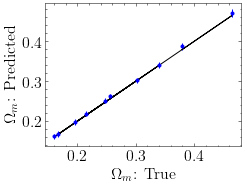

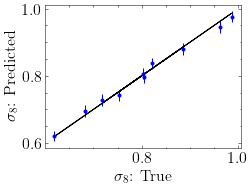

#####################################################


In [18]:
resultlist = evaluate.plot_param_inference_network_predictions(truedict, cmodel, device, save_config={})

### Add noise and save fields

In [18]:
import numpy as np

std_values = [0.01, 0.02, 0.05]
noisy_tensors = []
rng = np.random.default_rng(29)

for std in std_values:
    noise = rng.normal(0, std, truefields.shape)
    noisy_tensor = truefields + noise
    noisy_tensors.append(noisy_tensor)


In [19]:
truedict = {'params': trueparams, 'models': ['True Fields']+ [f'Std_{s}' for s in std_values], 
    'samples': [torch.tensor(t) for t in [truefields]+noisy_tensors], 'labels_subset': np.array([0, 1])}

Results for Samples from  True Fields
9.793 < F(all|resc)  < 14.669
Mean-norm={10.984}, Std-norm={0.508}
-2.343 < F(all|norm) < 7.251

Number of maps in the test set: 10
False
Test loss = -1.302e+01

Normalized Error Omega_m = 0.011
Normalized Error sigma_8 = 0.027
Normalized Error A_SN1   = 0.282
Normalized Error A_AGN1  = 0.297
Normalized Error A_SN2   = 0.282
Normalized Error A_AGN2  = 0.323

Error Omega_m = 0.004
Error sigma_8 = 0.011
Error A_SN1   = 1.057
Error A_AGN1  = 1.115
Error A_SN2   = 0.423
Error A_AGN2  = 0.484

Bayesian error Omega_m = 0.007
Bayesian error sigma_8 = 0.017
Bayesian error A_SN1   = 1.016
Bayesian error A_AGN1  = 1.050
Bayesian error A_SN2   = 0.340
Bayesian error A_AGN2  = 0.434

Relative error Omega_m = 0.015
Relative error sigma_8 = 0.014
Relative error A_SN1   = 1.258
Relative error A_AGN1  = 1.710
Relative error A_SN2   = 0.481
Relative error A_AGN2  = 0.611

PNAS "Accuracy", (Precision) Omega_m = 2.939
PNAS "Accuracy", (Precision) sigma_8 = 2.142


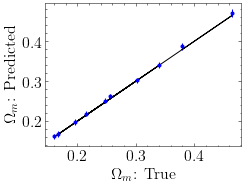

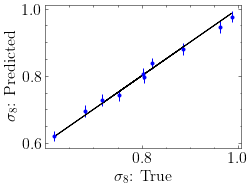

#####################################################
Results for Samples from  Std_0.01
9.788 < F(all|resc)  < 14.680
Mean-norm={10.984}, Std-norm={0.508}
-2.353 < F(all|norm) < 7.272

Number of maps in the test set: 10
False
Test loss = -9.728e+00

Normalized Error Omega_m = 0.053
Normalized Error sigma_8 = 0.107
Normalized Error A_SN1   = 0.272
Normalized Error A_AGN1  = 0.317
Normalized Error A_SN2   = 0.312
Normalized Error A_AGN2  = 0.338

Error Omega_m = 0.021
Error sigma_8 = 0.043
Error A_SN1   = 1.021
Error A_AGN1  = 1.188
Error A_SN2   = 0.468
Error A_AGN2  = 0.507

Bayesian error Omega_m = 0.008
Bayesian error sigma_8 = 0.017
Bayesian error A_SN1   = 0.964
Bayesian error A_AGN1  = 1.021
Bayesian error A_SN2   = 0.339
Bayesian error A_AGN2  = 0.401

Relative error Omega_m = 0.064
Relative error sigma_8 = 0.056
Relative error A_SN1   = 0.934
Relative error A_AGN1  = 1.773
Relative error A_SN2   = 0.452
Relative error A_AGN2  = 0.610

PNAS "Accuracy", (Precision) Omega_m = 3.19

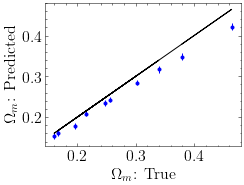

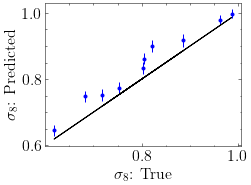

#####################################################
Results for Samples from  Std_0.02
9.796 < F(all|resc)  < 14.691
Mean-norm={10.984}, Std-norm={0.508}
-2.337 < F(all|norm) < 7.294

Number of maps in the test set: 10
False
Test loss = -6.639e+00

Normalized Error Omega_m = 0.185
Normalized Error sigma_8 = 0.336
Normalized Error A_SN1   = 0.396
Normalized Error A_AGN1  = 0.305
Normalized Error A_SN2   = 0.388
Normalized Error A_AGN2  = 0.335

Error Omega_m = 0.074
Error sigma_8 = 0.135
Error A_SN1   = 1.485
Error A_AGN1  = 1.144
Error A_SN2   = 0.583
Error A_AGN2  = 0.503

Bayesian error Omega_m = 0.008
Bayesian error sigma_8 = 0.017
Bayesian error A_SN1   = 0.553
Bayesian error A_AGN1  = 1.044
Bayesian error A_SN2   = 0.228
Bayesian error A_AGN2  = 0.322

Relative error Omega_m = 0.231
Relative error sigma_8 = 0.176
Relative error A_SN1   = 1.410
Relative error A_AGN1  = 1.701
Relative error A_SN2   = 0.396
Relative error A_AGN2  = 0.587

PNAS "Accuracy", (Precision) Omega_m = 4.26

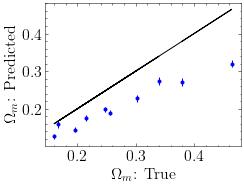

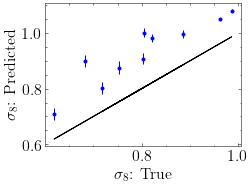

#####################################################
Results for Samples from  Std_0.05
9.732 < F(all|resc)  < 14.675
Mean-norm={10.984}, Std-norm={0.508}
-2.464 < F(all|norm) < 7.262

Number of maps in the test set: 10
False
Test loss = -1.604e+00

Normalized Error Omega_m = 0.483
Normalized Error sigma_8 = 0.931
Normalized Error A_SN1   = 2.140
Normalized Error A_AGN1  = 0.389
Normalized Error A_SN2   = 0.789
Normalized Error A_AGN2  = 0.438

Error Omega_m = 0.193
Error sigma_8 = 0.372
Error A_SN1   = 8.025
Error A_AGN1  = 1.459
Error A_SN2   = 1.184
Error A_AGN2  = 0.656

Bayesian error Omega_m = 0.014
Bayesian error sigma_8 = 0.005
Bayesian error A_SN1   = 7.000
Bayesian error A_AGN1  = 0.244
Bayesian error A_SN2   = 0.016
Bayesian error A_AGN2  = 0.033

Relative error Omega_m = 0.640
Relative error sigma_8 = 0.482
Relative error A_SN1   = 9.694
Relative error A_AGN1  = 1.345
Relative error A_SN2   = 1.032
Relative error A_AGN2  = 0.469

PNAS "Accuracy", (Precision) Omega_m = 15.8

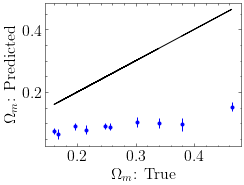

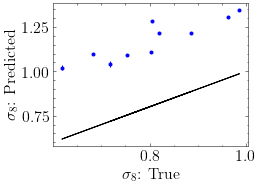

#####################################################


In [20]:
resultlist = evaluate.plot_param_inference_network_predictions(truedict, cmodel, device, save_config={})

In [22]:
len(resultlist)

4

In [23]:
truedict['samples'] = [t.detach().cpu().numpy() for t in truedict['samples']]

In [24]:
type(truedict['samples'][0])

numpy.ndarray

In [25]:
truedict['results_paraminf'] = resultlist

In [26]:
#pickle.dump(truedict, open('Figures/Final/InfNet/param_inf_results.pkl', 'wb'))

In [27]:
truedict['models']

['True Fields', 'Std_0.01', 'Std_0.02', 'Std_0.05']

In [28]:
truedict['params']

array([[0.2482 , 0.8034 , 1.96973, 0.42988, 0.64573, 0.59337],
       [0.1602 , 0.7174 , 3.56524, 0.855  , 0.90563, 0.51015],
       [0.3394 , 0.9626 , 0.75471, 0.93952, 1.21841, 1.68063],
       [0.167  , 0.9862 , 0.42514, 0.60963, 1.13682, 1.35754],
       [0.2558 , 0.7538 , 0.48431, 0.75471, 0.8162 , 0.57554],
       [0.303  , 0.8206 , 1.74836, 0.55478, 0.67971, 0.88332],
       [0.215  , 0.8858 , 1.68179, 3.06949, 1.58118, 1.9066 ],
       [0.1966 , 0.6186 , 0.47897, 0.47764, 1.99861, 1.11342],
       [0.4642 , 0.6826 , 3.38229, 2.87189, 0.60836, 1.93858],
       [0.3794 , 0.8046 , 2.78562, 1.29594, 0.97739, 1.03311]],
      dtype=float32)

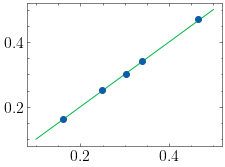

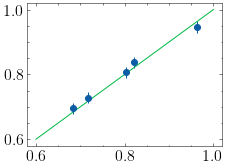

In [37]:
res = resultlist[0]
true, mean, std = res
subset = [0, 1, 2, 5, 8]
plt.figure()
plt.errorbar(true[subset, 0], mean[subset, 0], yerr=std[subset, 0], fmt='o')
plt.plot(np.linspace(0.1, 0.5, 50), np.linspace(0.1, 0.5, 50))
plt.show()

plt.figure()
plt.errorbar(true[subset, 1], mean[subset, 1], yerr=std[subset, 1], fmt='o')
plt.plot(np.linspace(0.6, 1.0, 50), np.linspace(0.6, 1.0, 50))
plt.show()

### Plot: Comparison figures

In [13]:
basedir = '../diffusion-models-for-cosmological-fields/annotated/results/hmc_samps/exp3_param1d/'

In [14]:
rdir = '../diffusion-models-for-cosmological-fields/annotated/results/hmc_samps/exp4_robustness/'

In [15]:
def get_hmc_dir_mapping(idx_noise, idx_field):
    nmap = {1: '0.01', 2: '0.02', 3: '0.05'}
    if idx_noise==0 and idx_field==8:
        return os.path.join(basedir, 'param_set2_0')
    elif idx_noise==0:
        return os.path.join(basedir, f'param_{idx_field}')
    else:
        nname = nmap[idx_noise]
        return os.path.join(rdir, f'Std_{nname}_field-{idx_field}')


In [16]:
infnetresults = pickle.load(open('Figures/Final/InfNet/param_inf_results.pkl', 'rb'))

In [17]:
infnetresults.keys(), len(infnetresults['results_paraminf'])

(dict_keys(['params', 'models', 'samples', 'labels_subset', 'results_paraminf']),
 4)

In [18]:
IFIELDS = [0,1,2,5,8]
BURN = 100
fcol = '#085c64'

In [19]:
nmap = {1: '0.01', 2: '0.02', 3: '0.05'}
nlabels=['$x_0$', '$x_0 + 0.01\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$', '$x_0 + 0.02\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$', f'$x_0 + 0.05\epsilon, \epsilon\sim\mathcal{{N}}(0, 1)$']

In [20]:
nlabels

['$x_0$',
 '$x_0 + 0.01\\epsilon, \\epsilon\\sim\\mathcal{{N}}(0, 1)$',
 '$x_0 + 0.02\\epsilon, \\epsilon\\sim\\mathcal{{N}}(0, 1)$',
 '$x_0 + 0.05\\epsilon, \\epsilon\\sim\\mathcal{N}(0, 1)$']

In [21]:
fdict = pickle.load(open('Figures/Final/InfNet/param_inf_results.pkl', 'rb'))

In [22]:
fdict.keys()

dict_keys(['params', 'models', 'samples', 'labels_subset', 'results_paraminf'])

In [23]:
fdict['models'] # is noise levels

['True Fields', 'Std_0.01', 'Std_0.02', 'Std_0.05']

In [24]:
len(fdict['samples'])

4

In [25]:
fdict['samples'][0].shape

(10, 1, 256, 256)

In [25]:
EG_ID=2

In [27]:
EG_ID = 2

In [38]:
INOISES = [0, 1, 2]
# Generate dummy image data
images = [fdict['samples'][inoise][EG_ID, 0] for inoise in INOISES]  # Placeholder for your actual image data
# Generate Pk
k2pk = False
percentiles = True
select_k = True
logscale = True
put_wavenumber_on_x = True

kvals, pklist = evaluate.get_powspec_for_samples([10**np.expand_dims(img, axis=0) for img in images], normalize=True)
k_idx = np.unique(np.arange(len(kvals))[np.logspace(0, np.log10(len(kvals)), 50).astype(int)])


In [39]:
import matplotlib.gridspec as gridspec

In [40]:
pklist[0].shape

(1, 128)

In [69]:
infnetresults['results_paraminf'][inoise][0][EG_ID, 0], infnetresults['results_paraminf'][inoise][0][EG_ID, 1]

(0.3394, 0.9626)

In [70]:
inoise

2

In [71]:
infnetresults['results_paraminf'][0][0][EG_ID, 0], infnetresults['results_paraminf'][0][0][EG_ID, 1]

(0.3394, 0.9626)

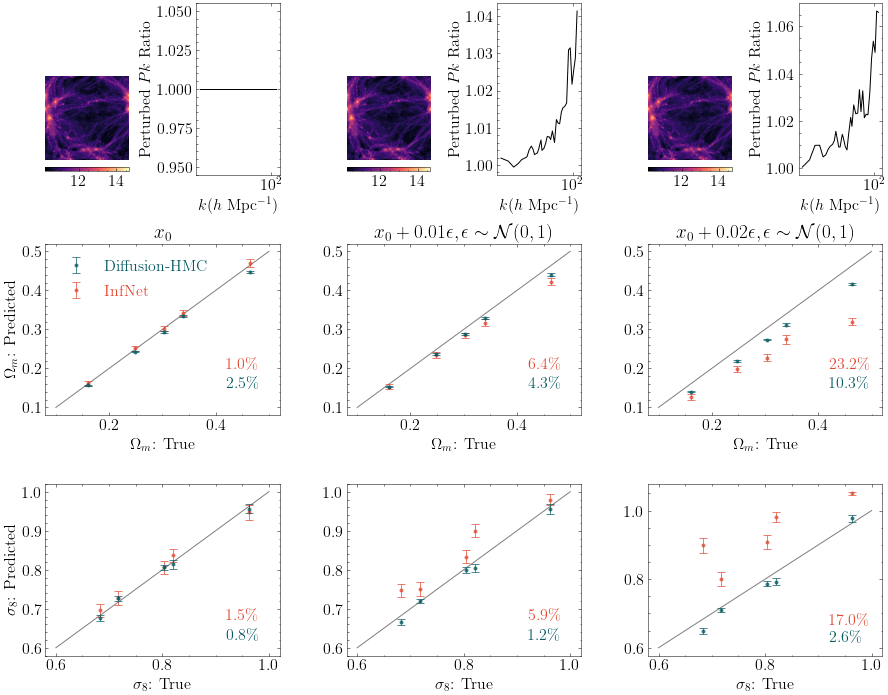

In [66]:
# Create the figure with a specific GridSpec layout
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(3, 6, height_ratios=[1]*3, width_ratios=[1]*6, hspace=0.4, wspace=0.8)

# Adding smaller axes at the top for images in the same row
ax_image1 = [fig.add_subplot(gs[0, 2*i]) for i in range(3)]
ax_image2 = [fig.add_subplot(gs[0, 2*i+1]) for i in range(3)]

for i in INOISES:
    # Display images in the first row
    im1 = ax_image1[i].imshow(images[i], cmap='magma')
    ax_image1[i].axis('off')  # Turn off axis
    plt.colorbar(im1, ax=ax_image1[i], orientation='horizontal', fraction=0.046, pad=0.04)
    ax_image2[i].plot(kvals[k_idx], pklist[i][0, k_idx]/pklist[0][0, k_idx], c='k') #ratio of noisy pk/ pk original
    ax_image2[i].set_xscale('log')
    ax_image2[i].set_ylabel(f'Perturbed $Pk$ Ratio')
    ax_image2[i].set_xlabel(r'$k (h$ Mpc$^{-1}$)')

# Create axes for the plots below using the remaining rows in GridSpec
for inoise in INOISES:
    om_gt, om_pred, om_pcts = [], [], []
    sig8_gt, sig8_pred, sig8_pcts = [], [], []

    for ifield in IFIELDS:
        pdir = get_hmc_dir_mapping(inoise, ifield)
        config = pickle.load(open(pdir+'/config.pkl', 'rb'))
        psamps = np.load(pdir+'/samps.npy')
        psubset = psamps[BURN:]
        
        om_gt.append(config['trueparam'].flatten()[0])
        sig8_gt.append(config['trueparam'].flatten()[1])
        om_pred.append(psubset[:, 0].mean())
        sig8_pred.append(psubset[:, 1].mean())
        
        om_pcts.append([np.percentile(psubset[:, 0], 15.87), np.percentile(psubset[:, 0], 84.13)])
        sig8_pcts.append([np.percentile(psubset[:, 1], 15.87), np.percentile(psubset[:, 1], 84.13)])

    om_pcts = np.vstack(om_pcts)
    sig8_pcts = np.vstack(sig8_pcts)
    om_pred = np.array(om_pred)
    sig8_pred = np.array(sig8_pred)
    om_bias_gt = np.mean(np.abs((om_pred - om_gt)/om_gt))*100
    sig8_bias_gt = np.mean(np.abs((sig8_pred - sig8_gt)/sig8_gt))*100

    # get param inf net predictions
    om_gt_in = infnetresults['results_paraminf'][inoise][0][IFIELDS, 0]
    om_pred_in = infnetresults['results_paraminf'][inoise][1][IFIELDS, 0]
    om_sig_in = infnetresults['results_paraminf'][inoise][2][IFIELDS, 0]
    sig8_gt_in = infnetresults['results_paraminf'][inoise][0][IFIELDS, 1]
    sig8_pred_in = infnetresults['results_paraminf'][inoise][1][IFIELDS, 1]
    sig8_sig_in = infnetresults['results_paraminf'][inoise][2][IFIELDS, 1]
    om_bias_gt_in = np.mean(np.abs((om_pred_in - om_gt_in)/om_gt_in))*100
    sig8_bias_gt_in = np.mean(np.abs((sig8_pred_in - sig8_gt_in)/sig8_gt_in))*100

    ax = fig.add_subplot(gs[1, 2*inoise:2*inoise+2])    
    ax.plot(np.linspace(0.1, 0.5, 50), np.linspace(0.1, 0.5, 50), c='k', alpha=0.5)
    ax.errorbar(om_gt, om_pred, (np.maximum(om_pred - om_pcts[:, 0], np.zeros(5)), np.maximum(om_pcts[:, 1]- om_pred, np.zeros(5))), fmt='o', markerfacecolor=fcol, markeredgecolor=fcol, color=fcol, markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='Diffusion-HMC', zorder=10, alpha=0.7)
    ax.errorbar(om_gt_in, om_pred_in, om_sig_in, fmt='o', markerfacecolor='#e34a33', markeredgecolor='#e34a33', color='#e34a33', markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='InfNet', alpha=0.7)
    ax.set_xlabel(r'$\Omega_m$: True')
    ax.annotate(f'{om_bias_gt:.1f}\%',xy=(0.42, 0.15), color=fcol) # xy=(0.05, 0.95),
    ax.annotate(f'{om_bias_gt_in:.1f}\%',xy=(0.42, 0.2),color='#e34a33')
    ax.set_title(nlabels[inoise])
    if inoise==0:
        ax.set_ylabel(r'$\Omega_m$: Predicted')
    if inoise==0:
        ax.legend(loc='upper left')
        leg = ax.get_legend()
        tcols = [fcol, '#e34a33']
        for i, text in enumerate(leg.get_texts()):
            text.set_color(tcols[i])

    ax = fig.add_subplot(gs[2, 2*inoise:2*inoise+2])
    ax.plot(np.linspace(0.6, 1.0, 50), np.linspace(0.6, 1, 50), c='k', alpha=0.5)
    ax.errorbar(sig8_gt, sig8_pred, (np.maximum(sig8_pred - sig8_pcts[:, 0], np.zeros(5)), np.maximum(sig8_pcts[:, 1]- sig8_pred, np.zeros(5))), fmt='o', markerfacecolor=fcol, markeredgecolor=fcol, color=fcol, markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='DM Prediction', zorder=10, alpha=0.7)
    ax.errorbar(sig8_gt_in, sig8_pred_in, sig8_sig_in, fmt='o', markerfacecolor='#e34a33', markeredgecolor='#e34a33', color='#e34a33', markersize=3, elinewidth=1, solid_capstyle='projecting', capsize=4, label='InfNet Prediction', alpha=0.7)
    ax.set_xlabel(r'$\sigma_8$: True')
    ax.annotate(f'{sig8_bias_gt:.1f}\%', xy=(0.92, 0.65), ha='left', va='top', color=fcol) # ,
    ax.annotate(f'{sig8_bias_gt_in:.1f}\%', xy=(0.92, 0.7), ha='left', va='top', color='#e34a33')

    if inoise==0:
        ax.set_ylabel(r'$\sigma_8$: Predicted')
plt.savefig('Figures/Final/noise_robustness_2panel_weg.pdf')
plt.show()